## Setup

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import os
import time
import json
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets

import config
from utils import *

os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [69]:
import openai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [70]:
from repl.server import LeanServer, RobustLeanServer

In [71]:
import json
import re
import os
import config

os.environ['OPENAI_API_KEY'] = config.OPENAI_API_KEY

import openai
openai.api_key = os.environ['OPENAI_API_KEY']

from litellm import completion
from openai import OpenAI
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from repl.server import LeanServer, RobustLeanServer

from config import *
from encoding_retrieval import retrieve

In [72]:
raise Exception("Don't run this cell")

Exception: Don't run this cell

## debug main

In [26]:
dataset = load_dataset(config.DATASET_NAME)
all_data = concatenate_datasets([dataset['test'], dataset['validation']])

Using the latest cached version of the dataset since agatha-duzan/number_theory_af couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/agatha/.cache/huggingface/datasets/agatha-duzan___number_theory_af/default/0.0.0/fd850084cc9308091015b3e2dbe4e0c6c2cb7ebf (last modified on Fri Nov 29 10:00:03 2024).


In [11]:
print(all_data)

Dataset({
    features: ['name', 'formal_statement', 'informal_statement', 'tags', 'header', 'split'],
    num_rows: 234
})


In [29]:
item = all_data[12]
informal_statement = item['informal_statement']
print(informal_statement)
print(item['formal_statement'])

How many integers between 15 and 85 are divisible by 20? Show that it is 4.
theorem mathd_numbertheory_12 :
    Finset.card (Finset.filter (fun x => 20 ∣ x) (Finset.Icc 15 85)) = 4 := by



In [27]:
formal_try = formal_statement = translate_statement(
    informal_statement,
    model=config.DEFAULT_MODEL,
    temperature=0.0,
    max_tokens=1000,
    )

In [28]:
print(formal_try)

theorem count_integers_divisible_by_20_between_15_and_85 : 
  {n : ℤ | 15 ≤ n ∧ n ≤ 85 ∧ 20 ∣ n}.card = 4 :=
sorry


In [52]:
results.append({
    'name': item['name'],
    'informal_statement': informal_statement,
    'generated_formal_statement': formal_statement,
    'formal_statement': item['formal_statement'],
    'tags': item['tags'],
    'header': item['header'],
    'split': item['split'],
    'model': config.DEFAULT_MODEL,
    'provider': config.DEFAULT_PROVIDER,
})

In [53]:
results

[{'name': 'f2f_numbertheory_4x3m7y3neq2003',
  'informal_statement': '/-- Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$.-/\n',
  'generated_formal_statement': 'theorem no_integers_solution : ¬ ∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := \nsorry',
  'formal_statement': 'theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 := by\n',
  'tags': "['number_theory']",
  'header': 'import Mathlib\nimport Aesop\n\nset_option maxHeartbeats 0\n\nopen BigOperators Real Nat Topology Rat\n\n',
  'split': 'test',
  'model': 'gpt-4o',
  'provider': 'openai'}]

In [59]:
output_file = os.path.join(config.RESULTS_DIR, f"{config.OUTPUT_NAME}_{config.DEFAULT_MODEL}.json")

with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results have been saved to {output_file}")

Results have been saved to results/evaluation/baseline_direct_translation_gpt-4o.json


## debug beq eval

In [2]:
import json
import os
import multiprocessing as mp
import re
import jsonlines
from multiprocessing.pool import Pool
from rich.console import Console
from rich.syntax import Syntax
from tqdm import tqdm
from beq_eval_cpu import BEqMetricCPU

import config
from eval import load_checkpoint, save_checkpoint
from pyleanrepl import RobustLeanServer, clean_cache

/home/agatha/.elan/bin/lake
Using device: cpu


In [36]:
beq_metric = BEqMetricCPU()

In [37]:
NB_PROCESS = 6

input_file = os.path.join(config.RESULTS_DIR, f"{config.OUTPUT_NAME}_{config.DEFAULT_MODEL}.json")
output_file = os.path.join(config.EVAL_RESULTS_DIR, f"{config.OUTPUT_NAME}_{config.DEFAULT_MODEL}_evaluated.json")
checkpoint_file = os.path.join(config.EVAL_RESULTS_DIR, f"{config.OUTPUT_NAME}_{config.DEFAULT_MODEL}_checkpoint.json")
os.makedirs(config.EVAL_RESULTS_DIR, exist_ok=True)

with open(input_file, 'r') as f:
    data = json.load(f)

In [38]:
empty_header_count = sum(1 for item in data if not item['header'].strip())
print(f"Number of rows with empty 'header': {empty_header_count}")

for item in data:
    if not item['header'].strip():
        item['header'] = 'import Mathlib'

empty_header_count = sum(1 for item in data if not item['header'].strip())
print(f"Number of rows with empty 'header': {empty_header_count}")

Number of rows with empty 'header': 52
Number of rows with empty 'header': 0


In [39]:
# Load checkpoint if it exists and get already processed entries
results = load_checkpoint(checkpoint_file)
processed_entries = {entry["name"] for entry in results}

In [41]:
for i in range(0, len(data), NB_PROCESS):
    batch = data[i:i + NB_PROCESS]
    formalization_pairs = [
            (entry["formal_statement"], entry["generated_formal_statement"], entry["header"])
            for entry in batch if entry["name"] not in processed_entries
        ]
    if not formalization_pairs:
            continue
    res = beq_metric(formalization_pairs, verbose=True, nb_process=NB_PROCESS)
    res = [int(eval_result) for eval_result in res]
    

    break

BEq CPU - metric computation: 100%|██████████| 6/6 [00:41<00:00,  6.84s/it]


In [43]:
print(res)

[1, 0, 0, 0, 0, 0]


In [45]:
eval_paths = [
    "/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/evaluations/base_hypothesis_decomp_gpt-4o_eval1.json",
    "/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/evaluations/baseline_direct_translation_gpt-4o_eval1.json",
    "/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/evaluations/direct_translation_with_general_fewshot_gpt-4o_eval1.json"
]

for eval_path in eval_paths:
    with open(eval_path, 'r') as f:
        data = json.load(f)

    for entry in data:
        repl_errors = entry["repl_errors"]
        if isinstance(repl_errors, str):
            repl = 0  # an exception occurred
        else:
            repl = 0 if any(error["severity"] == "error" for error in repl_errors) else 1

        entry["repl"] = repl
        if entry['repl'] == 0:
            entry['beq'] = 0

    with open(eval_path, 'w') as f:
        json.dump(data, f, indent=2)

In [12]:
path1 = "results/evaluations/direct_translation_with_general_fewshot_gpt-4o_eval1.json"
path2 = "results/evaluations/direct_translation_with_general_fewshot_gpt-4o_eval2.json"

with open(path1, 'r') as f:
    data = json.load(f)
with open(path2, 'r') as f:
    results = json.load(f)

data_done = [item for item in data if item['repl'] == 0]

all_data = data_done + results

In [13]:
print(len(data))
print(len(data_done))
print(len(results))
print(len(all_data))

234
124
110
234


In [14]:
with open(path2, 'w') as f:
    json.dump(all_data, f, indent=2)

## checking results

In [8]:
json_file_path = '/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/results/generations/direct_translation_with_general_fewshot_gpt-4o.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,name,informal_statement,generated_formal_statement,formal_statement,tags,header,split,model,provider
0,f2f_numbertheory_4x3m7y3neq2003,/-- Show that there are no integers $x$ and $y...,theorem no_integers_satisfy_equation : ¬∃ (x y...,theorem numbertheory_4x3m7y3neq2003 (x y : ℤ) ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
1,f2f_mathd_numbertheory_3,/-- What is the units digit of the sum of the ...,theorem units_digit_sum_squares_first_nine : \...,theorem mathd_numbertheory_3 : (∑ x in Finset....,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
2,f2f_mathd_numbertheory_1124,/-- The four-digit number $\underline{374n}$ i...,theorem units_digit_of_divisible_by_18 : ∃ n :...,theorem mathd_numbertheory_1124 (n : ℕ) (h₀ : ...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
3,f2f_mathd_numbertheory_237,/-- What is the modulo $6$ remainder of the su...,theorem sum_mod_six_remainder : (∑ i in Finset...,theorem mathd_numbertheory_237 : (∑ k in Finse...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai
4,f2f_mathd_numbertheory_299,/-- What is the ones digit of $1 \cdot 3 \cdot...,theorem ones_digit_of_product_is_five : (1 * 3...,theorem mathd_numbertheory_299 : 1 * 3 * 5 * 7...,['number_theory'],import Mathlib\nimport Aesop\n\nset_option max...,test,gpt-4o,openai


## debug eval

### REPL:

In [9]:
lean_server = RobustLeanServer()

In [10]:
txt = df.iloc[0].header + df.iloc[0].generated_formal_statement
print(txt)

result = lean_server.run_code(txt)
print(result['messages'])

import Mathlib
import Aesop

set_option maxHeartbeats 0

open BigOperators Real Nat Topology Rat

theorem no_integers_satisfy_equation : ¬∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 := sorry
[{'severity': 'warning', 'pos': {'line': 8, 'column': 8}, 'endPos': {'line': 8, 'column': 36}, 'data': "declaration uses 'sorry'"}]


In [20]:
n = 210
txt = "import Mathlib\n\n"+df.iloc[n].header + df.iloc[n].generated_formal_statement
print(txt)
result = lean_server.run_code(txt, timeout=60)
messages = result['messages']
print(messages)

import Mathlib

theorem exists_infinitely_many_n_for_prime_divisors {k : ℕ} :
  ∃ᶠ n in at_top, ∀ p : ℕ, p.Prime → p ∣ n^2 + 3 → ∃ k : ℤ, k^2 < n ∧ p ∣ k^2 + 3 := sorry
[{'severity': 'error', 'pos': {'line': 4, 'column': 74}, 'endPos': {'line': 4, 'column': 81}, 'data': 'failed to synthesize\n  HAdd ℤ ℤ ℕ\nAdditional diagnostic information may be available using the `set_option diagnostics true` command.'}]


In [34]:
get_repl_errors(df.iloc[n].generated_formal_statement, df.iloc[n].header, lean_server)

[{'severity': 'error',
  'pos': {'line': 3, 'column': 96},
  'endPos': {'line': 3, 'column': 103},
  'data': 'failed to synthesize\n  HAdd ℤ ℤ ℕ\nAdditional diagnostic information may be available using the `set_option diagnostics true` command.'}]

### BLEU:

In [13]:
generated = clean_theorem_string(df.iloc[0].generated_formal_statement)
reference = clean_theorem_string(df.iloc[0].formal_statement)
print(f"Generated: \n{generated}\n\nReference: \n{reference}")

Generated: 
theorem dummy : ¬∃ (x y : ℤ), 4 * x^3 - 7 * y^3 = 2003 :=
sorry

Reference: 
theorem dummy (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 :=
sorry


In [14]:
bleu_eval(generated, reference)

0.15421048160685175

### Cosine sim

In [15]:
cos_similarity(generated, reference)

0.9802588087715985

### lil data analysis

In [16]:
json_file_path = 'results/evaluations/direct_translation_with_general_fewshot_gpt-4o_evaluated.json'
with open(json_file_path, 'r') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

FileNotFoundError: [Errno 2] No such file or directory: 'results/evaluations/direct_translation_with_general_fewshot_gpt-4o_evaluated.json'

In [105]:
df['ref_len'] = df['formal_statement'].apply(len)
df['gen_len'] = df['generated_formal_statement'].apply(len)
df['ends_with_sorry'] = df['generated_formal_statement'].str.endswith('sorry')

In [110]:
summary_stats = df[['bleu', 'cosine_similarity', 'ref_len', 'gen_len']].describe()
print(summary_stats)

             bleu  cosine_similarity     ref_len      gen_len
count  234.000000         234.000000  234.000000   234.000000
mean     0.271398           0.892410  159.230769   174.004274
std      0.254483           0.026621  102.329929   207.671528
min      0.000198           0.806644   49.000000    42.000000
25%      0.081127           0.875569   84.000000    95.000000
50%      0.194772           0.894469  128.000000   137.000000
75%      0.390686           0.912456  199.750000   191.000000
max      1.000000           0.944266  757.000000  2546.000000


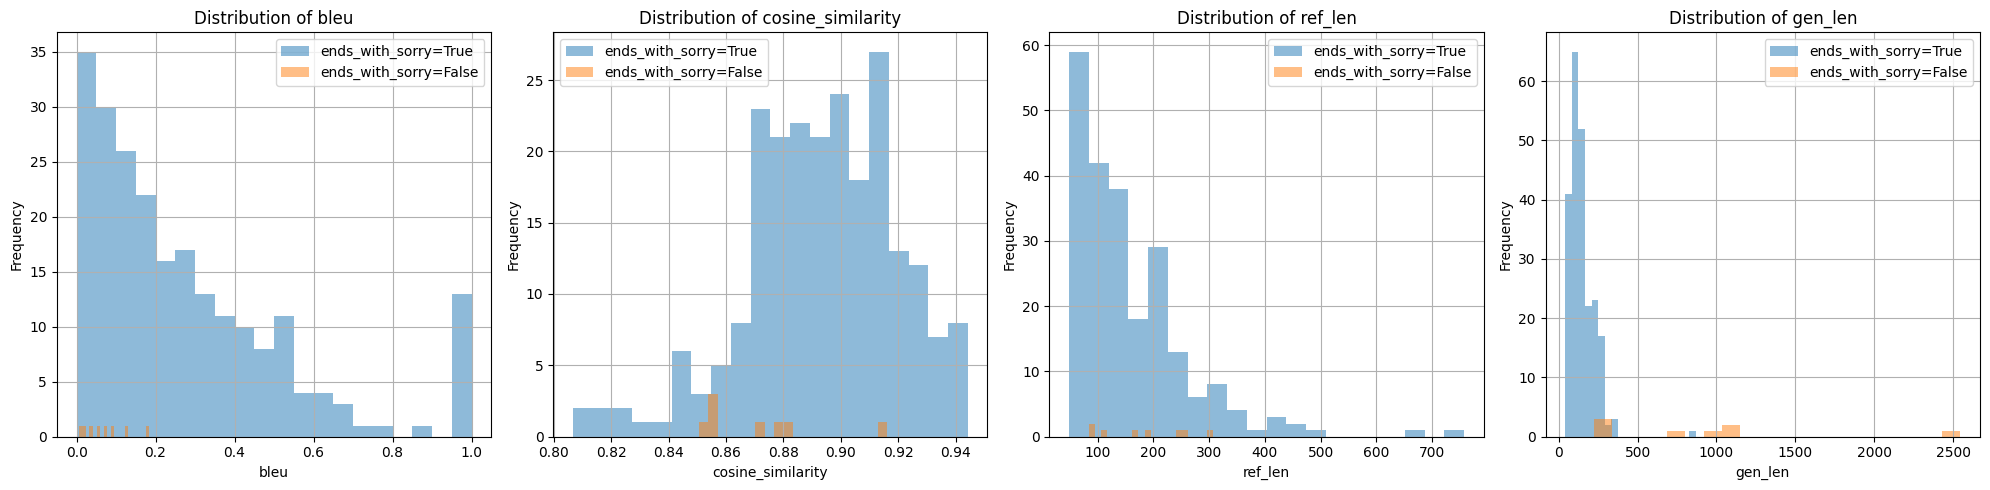

In [120]:
import matplotlib.pyplot as plt

columns = ['bleu', 'cosine_similarity', 'ref_len', 'gen_len']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # figsize controls the overall size of the plot

for ax, column in zip(axes, columns):
    df[df['ends_with_sorry'] == True][column].hist(bins=20, alpha=0.5, label='ends_with_sorry=True', ax=ax)
    df[df['ends_with_sorry'] == False][column].hist(bins=20, alpha=0.5, label='ends_with_sorry=False', ax=ax)
    
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


In [113]:
correlation_matrix = df[['bleu', 'cosine_similarity', 'ref_len', 'gen_len']].corr()
print(correlation_matrix)

                       bleu  cosine_similarity   ref_len   gen_len
bleu               1.000000           0.204905 -0.436111 -0.257112
cosine_similarity  0.204905           1.000000  0.167958 -0.066965
ref_len           -0.436111           0.167958  1.000000  0.299346
gen_len           -0.257112          -0.066965  0.299346  1.000000


In [115]:
sorry_analysis = df.groupby('ends_with_sorry')[['bleu', 'cosine_similarity']].mean()
print(sorry_analysis)

                     bleu  cosine_similarity
ends_with_sorry                             
False            0.074589           0.870529
True             0.278365           0.893185


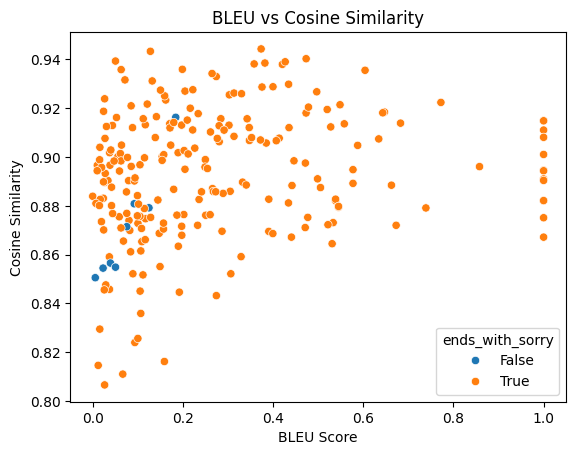

In [116]:
import seaborn as sns

plt.figure()
sns.scatterplot(data=df, x='bleu', y='cosine_similarity', hue='ends_with_sorry')
plt.title('BLEU vs Cosine Similarity')
plt.xlabel('BLEU Score')
plt.ylabel('Cosine Similarity')
plt.show()

## hypothesis decomp

### understanding the format

from fewshot:

In [22]:
statement = "theorem exists_le_sylow\n [Group G] {P : Subgroup G} (hP : IsPGroup p P) : ∃ Q : Sylow p G, P ≤ Q \n:= sorry"
print(statement)

theorem exists_le_sylow
 [Group G] {P : Subgroup G} (hP : IsPGroup p P) : ∃ Q : Sylow p G, P ≤ Q 
:= sorry


from original dataset:

In [21]:
statement = "theorem numbertheory_4x3m7y3neq2003\n (x y : \u2124) : 4 * x ^ 3 - 7 * y ^ 3 \u2260 2003 \n:= sorry"
print(statement)

theorem numbertheory_4x3m7y3neq2003
 (x y : ℤ) : 4 * x ^ 3 - 7 * y ^ 3 ≠ 2003 
:= sorry


generated:

In [24]:
statement = "theorem sum_of_nice_numbers : \n  let is_nice (n : \u2115) : Prop := \n    \u2203 m : \u2115, m > 0 \u2227 (\u2203 a b : \u2115, a * b = m \u2227 a \u2260 b \u2227 a > 0 \u2227 b > 0 \u2227 a + b + 1 + m = n)\n  in (\u2211 n in finset.range 2020 \\ finset.range 2010, if is_nice n then n else 0) = 2016 :=\nsorry"
print(statement)


theorem sum_of_nice_numbers : 
  let is_nice (n : ℕ) : Prop := 
    ∃ m : ℕ, m > 0 ∧ (∃ a b : ℕ, a * b = m ∧ a ≠ b ∧ a > 0 ∧ b > 0 ∧ a + b + 1 + m = n)
  in (∑ n in finset.range 2020 \ finset.range 2010, if is_nice n then n else 0) = 2016 :=
sorry


In [25]:
statement = "theorem f_divides_f {m n : \u2115} (hm : 0 < m) (hn : 0 < n) (h : m \u2264 n) :\n    let f (x : \u2115) := 4^x + 6^x + 9^x\n    in f (2^m) \u2223 f (2^n) :=\n  sorry"
print(statement)


theorem f_divides_f {m n : ℕ} (hm : 0 < m) (hn : 0 < n) (h : m ≤ n) :
    let f (x : ℕ) := 4^x + 6^x + 9^x
    in f (2^m) ∣ f (2^n) :=
  sorry


### trying stuff

## retrieval

In [1]:
from encoding_retrieval import *

Using device: cpu


In [2]:
tokenizer = AutoTokenizer.from_pretrained("kaiyuy/leandojo-lean4-retriever-byt5-small")
model = AutoModelForTextEncoding.from_pretrained("kaiyuy/leandojo-lean4-retriever-byt5-small")
model.eval()
model.to(device)

premises, encodings = get_premises_and_encodings(premises_file = "/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/data/premises_defs.pkl")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### filter out thm and lemma

In [7]:
def is_theorem(premise):
    return 'theorem' in premise

def is_lemma(premise):
    return 'lemma' in premise

count = sum(1 for premise in premises if is_lemma(premise) or is_theorem(premise))
print(f"Number of theorems and lemmas: {count}")

Number of theorems and lemmas: 0


In [115]:
premises_keep = []
encodings_keep = []
for premise, encoding in zip(premises, encodings):
    if not (is_lemma(premise) or is_theorem(premise)):
        premises_keep.append(premise)
        encodings_keep.append(encoding)

encodings_keep = np.stack(encodings_keep)

In [117]:
data = {'premises': premises_keep, 'encodings': encodings_keep}
filename = 'data/premises_defs.pkl'

with open(filename, 'wb') as f:
    pickle.dump(data, f)
print(f"Premises and encodings saved to {filename}")

Premises and encodings saved to data/premises_defs.pkl


In [118]:
premises, encodings = get_premises_and_encodings(premises_file = "/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/data/premises_defs.pkl")

### improving retrieval

In [17]:
# FULL QUERY:
# query = """
# G : Type u_1
# p : ℕ
# inst✝ : Group G
# P : Subgroup G
# hP : IsPGroup p ↥P
# ⊢ ∃ Q, P ≤ ↑Q
# """

query = """
G : Type u_1
⊢ ∃ Q, P ≤ ↑Q
"""

k=5

result = retrieve(query, premises, encodings, k, tokenizer, model)
for res in result:
    print(res)

def BddAbove (s : Set α) :=
  (upperBounds s).Nonempty
class NoMinOrder (α : Type*) [LT α] : Prop where
  
  exists_lt (a : α) : ∃ b, b < a
class NoMaxOrder (α : Type*) [LT α] : Prop where
  
  exists_gt (a : α) : ∃ b, a < b
def BddBelow (s : Set α) :=
  (lowerBounds s).Nonempty
def lowerBounds (s : Set α) : Set α :=
  { x | ∀ ⦃a⦄, a ∈ s → x ≤ a }


## Leansearch

### querying

In [1]:
import requests

s = "test"
num_results = 10
x = requests.get(rf"https://leansearch.net/api/search?query={s}&num_results={num_results}")
print(x.json())

[{'id': 249140, 'formal_name': 'Nat.testBit_to_div_mod', 'formal_type': '∀ {i x : Nat}, testBit x i = decide (x / 2 ^ i % 2 = 1)', 'kind': 'theorem', 'file_name': 'Mathlib.Topology.Algebra.Order.Floor', 'doc_url': 'https://leanprover-community.github.io/mathlib4_docs/find/?pattern=Nat.testBit_to_div_mod#doc', 'docstring': ''}, {'id': 249154, 'formal_name': 'Nat.testBit_two_pow_sub_one', 'formal_type': '∀ (n i : Nat), testBit (2 ^ n - 1) i = decide (i < n)', 'kind': 'theorem', 'file_name': 'Mathlib.Topology.Algebra.Order.Floor', 'doc_url': 'https://leanprover-community.github.io/mathlib4_docs/find/?pattern=Nat.testBit_two_pow_sub_one#doc', 'docstring': ''}, {'id': 249145, 'formal_name': 'Nat.testBit_implies_ge', 'formal_type': '∀ {i x : Nat}, testBit x i = true → x ≥ 2 ^ i', 'kind': 'theorem', 'file_name': 'Mathlib.Topology.Algebra.Order.Floor', 'doc_url': 'https://leanprover-community.github.io/mathlib4_docs/find/?pattern=Nat.testBit_implies_ge#doc', 'docstring': ''}, {'id': 249139, 'f

In [3]:
from encoding_retrieval import *

Using device: cpu


In [4]:
subq = "Let $H$ be a subgroup of the additive group of ordered pairs of integers under componentwise addition. If $H$ is generated by the elements $(3, 8)$, $(4, -1)$, and $(5, 4)$, then $H$ is also generated by two elements $(1, b)$ and $(0, a)$ for some integer $b$ and positive integer $a$. Find $a$."

all = leansearch(subq, k=5)
print(all)

[]


In [5]:
for r in all:
    print(r)

In [5]:
import jsonlines

file_path = '/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/data/8_shot_proofnet_lean4_decomp.jsonl'
items_list = []
with jsonlines.open(file_path) as reader:
    for obj in reader:
        items_list.append(obj)

for item in items_list:
    dic = item['hyp_decomp']
    print(dic)

{'G is a group': 'definition of a group', 'P is a subgroup of G': 'definition of a subgroup', 'Q is a Sylow p-subgroup of G': 'definition of a Sylow p-subgroup', 'P is contained in Q': 'definition contained subgroup'}
{'E and F are normed spaces': 'definition of a normed space', 'E and F are complex spaces': 'definition of a complex space', 'f is a function from E to F': 'definition of a function', 'f is differentiable': 'definition of a differentiable function', 'f is bounded': 'definition of a bounded function', 'f is constant': 'definition of a constant function'}
{'f and g are multiplicative functions': 'definition multiplicative function', 'f and g are equal': 'definition equality of functions', 'f(p^i) = g(p^i) for all primes $p$': 'definition prime number'}
{'B is a bilinear form': 'definition of a bilinear form', '$\\{v_i\\}_{i\\in I}$ is an orthogonal set of vectors with respect to B': 'definition othogonal set of vectors', 'the set of vectors is independent': 'definition inde

### generation w LS

In [20]:
fs_path = '/home/agatha/Desktop/MA3/sem proj/autoformalization_with_hypothesis/data/8_shot_proofnet_lean4_decomp.jsonl'
fs = load_few_shot_examples(fs_path)

In [ ]:
informal_statement = "Show that there are no integers $x$ and $y$ such that $4x^3 - 7y^3 = 2003$."
instruction = f'''You are a helpful assistant specializing in mathematical reasoning. You will be given a mathematical statement in natural language. Your task is to:

1. Break down the statement into separate premises or components.
2. For each premise, propose a natural language query that will be used by a documentation search tool (Leansearch) to retrieve relevant Lean documentation or definitions.
3. Present the result as a dictionary in the following format,:

{{
    <premise in plain language>: <Leansearch query>,
    <premise in plain language>: <Leansearch query>,
    ...
}}

Make sure to:
- Identify all important objects, functions, sets, properties, and relationships within the statement.
- Generate a short natural language query for each premise. 
- Do not attempt to formalize the statement in Lean yet. Only provide the premises and corresponding queries.

Below are some examples:
'''
for item in fs:
    instruction += f"natural language statement: {item['nl_statement']} \n"
    instruction += f"hyp_decomp: {item['hyp_decomp']} \n\n"

instruction += f"Now it's your turn: \nnatural language statement: {informal_statement} \nhyp_decomp: "

print(instruction)

In [76]:
decomp = leansearch_hypothesis_decomp(informal_statement, fs)

In [77]:
decomp

{'x and y are integers': 'definition of integers',
 '4x^3 - 7y^3 = 2003': 'equation involving integers and powers'}

In [86]:
leansearch('definition diophantine equation')

[{'formal_name': 'Dioph',
  'formal_type': '{α : Type u} → Set (α → ℕ) → Prop',
  'file_name': 'Mathlib.MeasureTheory.Measure.Lebesgue.Complex',
  'docstring': 'A set `S ⊆ ℕ^α` is Diophantine if there exists a polynomial on\n  `α ⊕ β` such that `v ∈ S` iff there exists `t : ℕ^β` with `p (v, t) = 0`. '}]

In [84]:
retrieved = [leansearch(query) for query in decomp.values()]
for res in retrieved:
    print(res)

[{'formal_name': 'Int.infinite', 'formal_type': 'Infinite ℤ', 'file_name': 'Mathlib.Data.Finset.Lattice', 'docstring': ''}]
[]


In [90]:
prompt = generate_prompt(informal_statement, fs, retrieved=retrieved)

In [91]:
formal_statement = translate_statement(
    informal_statement,
    few_shot_examples = fs,
    retrieved = retrieved,
    model=config.DEFAULT_MODEL,
    temperature=0.0,
    max_tokens=1000,
    )

In [92]:
print(formal_statement)

theorem no_integers_satisfy_equation :
  ¬∃ (x y : ℤ), 4 * x ^ 3 - 7 * y ^ 3 = 2003 := sorry
